### Решение линейного стока для запуска и остановки скважины. Суперпозиция

Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

Версия 0.3 от 17.10.2025

---

Содержание

1. [Решение линейного стока](#341)
2. [Расчет кривой восстановления давления](#342)
3. [Построение графиков распределения давления в пласте при восстановлении давления](#343)
4. [Задания для самостоятельной работы](#344)

In [1]:
# импортируем библиотеки для расчетов

# numpy используем для работы с массивами и подготовки данных для построения графиков. 
# Также в некоторых функциях используем возможности векторных расчетов numpy
import numpy as np

# matplotlib используем для построения графиков
import matplotlib.pyplot as plt

# импортируем ранее определенные расчетные функции
import sys
sys.path.append('..') # модуль с функциями располагается на уровень выше скрипта
from welltest import functions as wf

# 2. Расчет кривой восстановления давления <a class="anchor" id="342"></a>

Один из самых простых примеров применения суперпозиции. Предполагаем, что добывающая скважина в однородном изотропном пласте запускается в момент времени `t=0` и работает `t_p_hr` часов, после чего останавливается. После остановки скважины забойное давление растет - и мы получим кривую восстановления давления.

Пусть решение задачи запуска скважины (падения давления) будет $P_D(t_D, r_D)$. Тогда решение для изменения давления при запуске и последующей остановки скважины можно представить в виде 
$$P_{bu.D}(t_D, t_{prod.D}, r_D) = P_D(t_D) - P_D(t_D-t_{prod.D}, r_D) \cdot \mathcal{H}(t_D-t_{prod.D})  \tag{14.1}$$

где
* $t_D$ - безразмерное время после запуска скважины,
* $t_{prod.D}$ - безразмерное время работы скважины после запуска
* $\mathcal{H}$ - ступенчатая [функция Хевисайда](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0) (в некоторых книгах обозначается как $\theta$)
* $P_D(t_D, r_D)$ - безразмерное давление - решение задачи запуска скважины (падения давления)
* $P_{bu.D}(t_D, t_{prod.D}, r_D)$ - безразмерное давление- решение задачи запуска скважины и последующей остановки скважины

Для проведения векторных расчетов в python удобно выражение с использованием функции Хевисайда

$$ \mathcal{H} = \begin{cases}0 & x < 0\\1 & x = 0\\1 & x > 0\end{cases}$$

Применение функции Хевисайда позволяет избежать в расчетных функциях применение условных операторов в явном виде для отдельных элементов входных массивов. Это потенциально ускоряет расчет. 


In [2]:
def pd_line_source_ei_build_up(td, td_p, rd):
    """
    расчет давления для запуска и последующей остановки скважины
    td - время после запуска
    td_p - время безразмерное - которое скважина работала до остановки
    rd - расстояния от скважины
    """
    
    # применение функции Хевисайда здесь делает расчет корректным
    # для входных векторов td
    return wf.pd_line_source_ei(td, rd) - np.heaviside(td-td_p,1) * wf.pd_line_source_ei(td-td_p, rd)

время работы скважины 24.00 часа, что соответсвует безразмерному времени 4320000.00


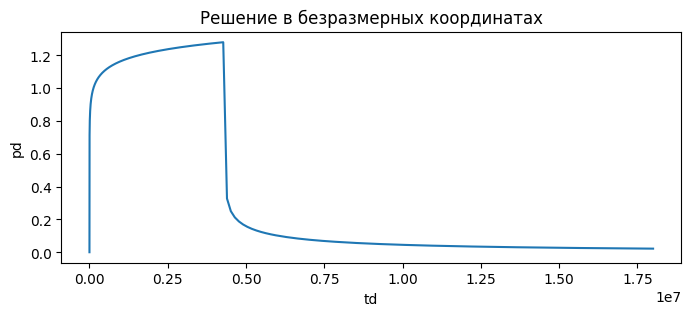

In [3]:
t_arr = np.logspace(-10, 2, 1000)
t_prod_hr = 24
k = 10   # проницаемость
q = 30   # дебит

# переведем размерный массив времени в безразмерные величины
# некоторые параметры можно было бы пропустить и оставить значения по умолчанию
# но для полноты приведем их в явном виде

td_arr = wf.td_from_t(t_arr, k_mD=k, phi=0.2, mu_cP=1, ct_1atm=1e-05, rw_m=0.1)
td_prod = wf.td_from_t(t_prod_hr, k_mD=k, phi=0.2, mu_cP=1, ct_1atm=1e-05, rw_m=0.1)

print('время работы скважины {:.2f} часа, что соответсвует безразмерному времени {:.2f}'.format(t_prod_hr, td_prod))

# для заданного массива безразмерных времен рассчитаем безразмерные давления
pd_arr = pd_line_source_ei_build_up(td_arr, td_prod, rd=1)

# построение графика
plt.rcParams["figure.figsize"] = (8,3)

plt.plot(td_arr, pd_arr)

plt.xlabel('td')
plt.ylabel('pd')
plt.title('Решение в безразмерных координатах')
plt.show()

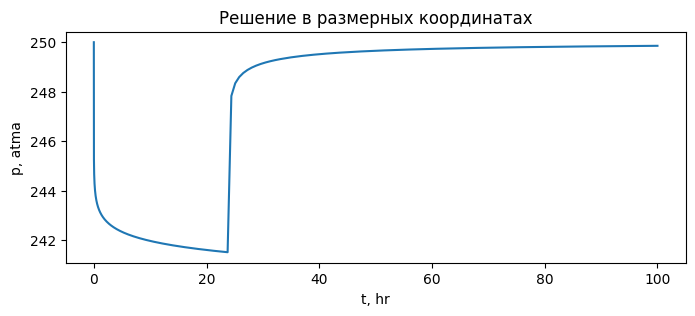

In [12]:
# переведем безразмерные координаты в размерные
p_arr = wf.p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250)

plt.rcParams["figure.figsize"] = (8,3)
plt.plot(t_arr, p_arr)
plt.xlabel('t, hr')
plt.ylabel('p, atma')
plt.title('Решение в размерных координатах')
plt.show()

# 3. Построение графиков распределения давления в пласте при восстановлении давления <a class="anchor" id="343"></a>

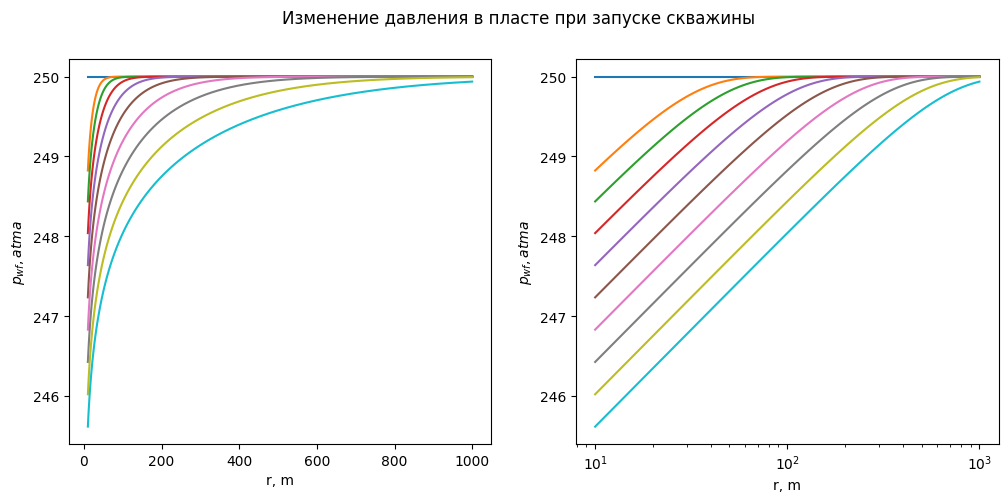

In [13]:
r_arr = np.logspace(1, 3, 100)
t_arr = np.logspace(-1, 2, 10)
t_arr[0] = 0.001
t_prod = 100

tv, rv = np.meshgrid(wf.td_from_t(t_arr),wf.rd_from_r(r_arr))
pd_arr = wf.pd_line_source_ei(tv, rd=rv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при запуске скважины')
ax1.plot(r_arr, wf.p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')

ax2.plot(r_arr,wf.p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()

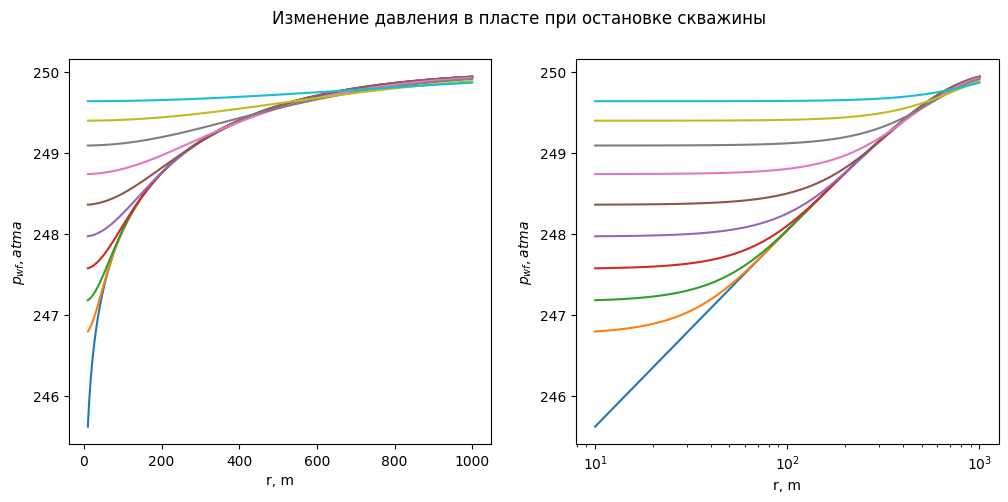

In [14]:
pd_arr_bu = wf.pd_line_source_ei(tv + wf.td_from_t(t_prod), rd=rv) - wf.pd_line_source_ei(tv, rd=rv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при остановке скважины')
ax1.plot(r_arr, wf.p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')

ax2.plot(r_arr,wf.p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()

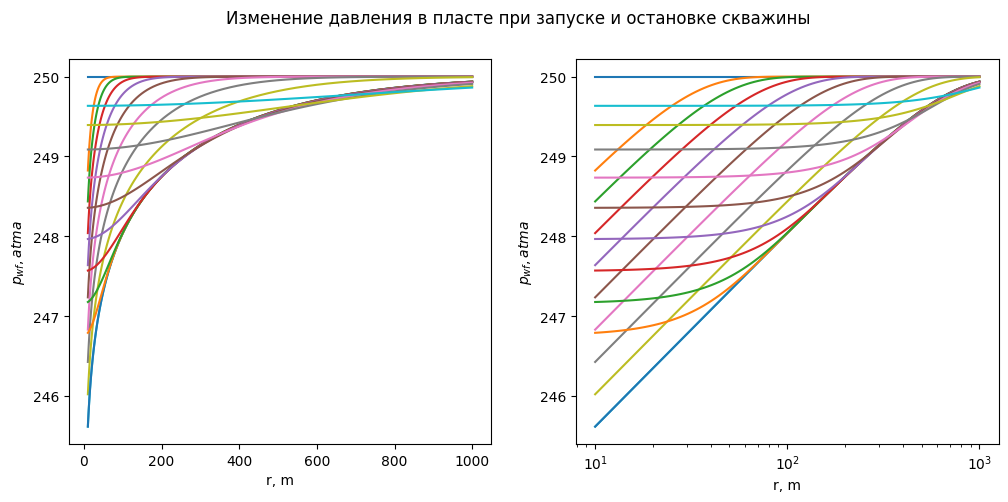

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при запуске и остановке скважины')
ax1.plot(r_arr, wf.p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.plot(r_arr, wf.p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')
ax2.plot(r_arr, wf.p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax2.plot(r_arr, wf.p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))

ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()

# 4 Задания для самостоятельной работы <a class="anchor" id="344"></a>

Для совершенствования навыков работы с python выполните следующие задания:

1. Постройте графики изменения давления в области дренирования при произвольном изменении дебитов